In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import copy
import pylab as pl
import time
from IPython import display


---
# VIDEO: Time-domain convolution
---


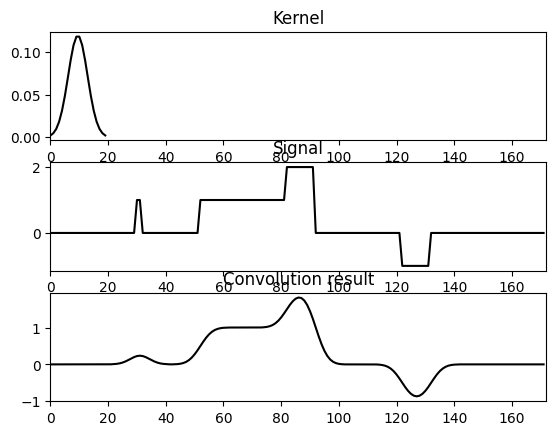

In [25]:
## first example to build intuition

signal1 = np.concatenate( (np.zeros(30),np.ones(2),np.zeros(20),np.ones(30),2*np.ones(10),np.zeros(30),-np.ones(10),np.zeros(40)) ,axis=0)
kernel  = np.exp( -np.linspace(-2,2,20)**2 )
kernel  = kernel/sum(kernel)
N = len(signal1)

plt.subplot(311)
plt.plot(kernel,'k')
plt.xlim([0,N])
plt.title('Kernel')

plt.subplot(312)
plt.plot(signal1,'k')
plt.xlim([0,N])
plt.title('Signal')

plt.subplot(313)
signal2 = np.convolve(signal1,kernel,'same')
plt.plot(signal2 ,'k')
plt.xlim([0,N])
plt.title('Convolution result')

plt.show()

In [82]:
# figure out where the samples go
n_samp = len(signal2)
samples = np.arange(0, len(signal2), 1)
times = samples / 100
times = np.unique(times)
# convert bounds to slsqp representation
bounds = []  # compatible with old version of scipy

# Build the convolution matrix
conv_mat = np.zeros((n_samp, len(samples)))
for li, loc in enumerate(samples):
    eidx = min(loc + len(kernel), n_samp)
    conv_mat[loc:eidx, li] = kernel[:eidx - loc]

## Tikhonov-regularized pseudoinverse

In [93]:
u, s, v = scipy.linalg.svd(conv_mat, full_matrices=False)
s[s < 1e-7 * s[0]] = 0
pos_s = s[s > 0]
s[s > 0] = pos_s / (pos_s ** 2 + 1)
inv_conv_mat = np.dot(v.T, s[:, np.newaxis] * u.T)
fit = np.dot(signal2, inv_conv_mat.T)

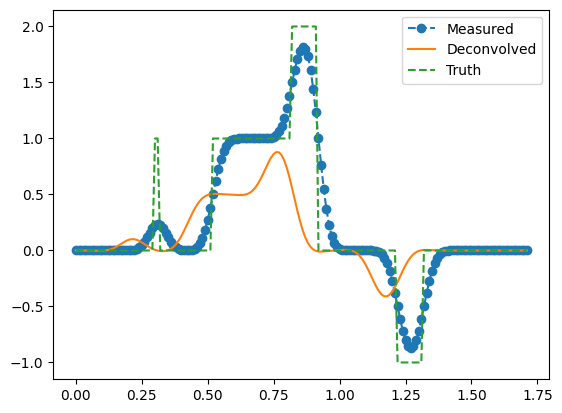

In [97]:
plt.plot(times, signal2, linestyle="--", marker="o", label="Measured")
plt.plot(times, fit, label="Deconvolved")
plt.plot(times, signal1, linestyle="--", label="Truth")
plt.legend()

## Least Squares Minimization

In [85]:
def _score(vals, x_0, conv_mat):
    return np.mean((x_0 - conv_mat.dot(vals)) ** 2)

In [98]:
x0 = np.zeros(conv_mat.shape[1])
fit = np.empty((1, conv_mat.shape[1]))
failed = np.empty(1)

out = scipy.optimize.fmin_slsqp(
    _score,
    x0,
    args=(signal2, conv_mat),
    epsilon=1e-4,
    bounds=bounds,
    disp=False,
    full_output=True,
    iter=500,
    acc=1e-6,
)
fit = out[0]
failed = out[3]

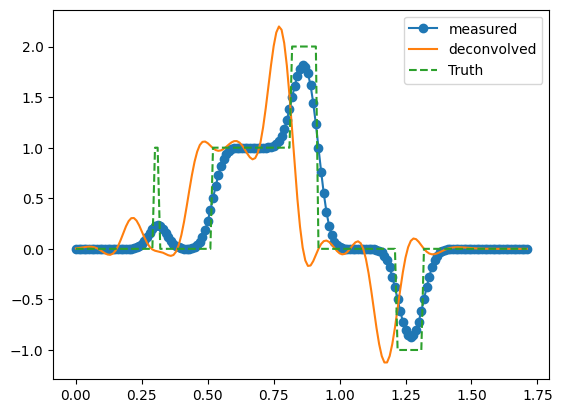

In [99]:
plt.plot(times,signal2, linestyle="-", marker="o", label="measured")
plt.plot(times, fit, label="deconvolved")
plt.plot(times, signal1, linestyle="--", label="Truth")
plt.legend()

## Richardson Lucy (Scikit-image implementation)

In [100]:
import skimage
fit = skimage.restoration.richardson_lucy(signal2, kernel)

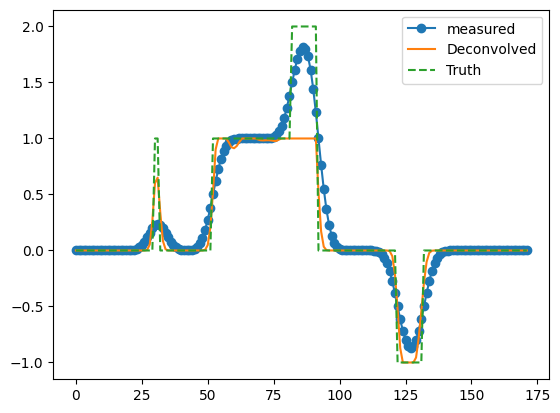

In [104]:
plt.plot(signal2, linestyle="-", marker="o", label="measured")
plt.plot(fit, label="Deconvolved")
plt.plot(signal1, linestyle="--", label="Truth")
plt.legend()

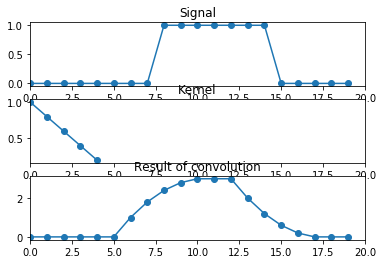

In [ ]:
## in a bit more detail

# signal
signal1 = np.zeros(20)
signal1[8:15] = 1

# convolution kernel
kernel = [1,.8,.6,.4,.2]

# convolution sizes
nSign = len(signal1)
nKern = len(kernel)
nConv = nSign + nKern - 1


# plot the signal
plt.subplot(311)
plt.plot(signal1,'o-')
plt.xlim([0,nSign])
plt.title('Signal')

# plot the kernel
plt.subplot(312)
plt.plot(kernel,'o-')
plt.xlim([0,nSign])
plt.title('Kernel')


# plot the result of convolution
plt.subplot(313)
plt.plot(np.convolve(signal1,kernel,'same'),'o-')
plt.xlim([0,nSign])
plt.title('Result of convolution')
plt.show()

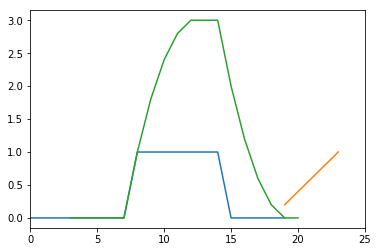

(20,)


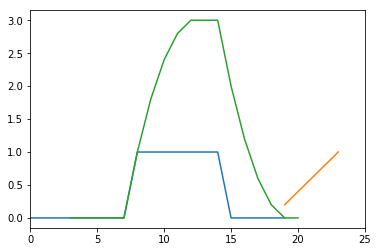

In [ ]:
## convolution in animation

half_kern = int( np.floor(nKern/2) )

# flipped version of kernel
kflip = kernel[::-1] #-np.mean(kernel)

# zero-padded data for convolution
dat4conv = np.concatenate( (np.zeros(half_kern),signal1,np.zeros(half_kern)) ,axis=0)

# initialize convolution output
conv_res = np.zeros(nConv)


# run convolution
for ti in range(half_kern,nConv-half_kern):

    # get a chunk of data
    tempdata = dat4conv[ti-half_kern:ti+half_kern+1]

    # compute dot product (don't forget to flip the kernel backwards!)
    conv_res[ti] = np.sum( tempdata*kflip )

    # draw plot
    pl.cla() # clear the axis
    plt.plot(signal1)
    plt.plot(np.arange(ti-half_kern,ti+half_kern+1),kflip)
    plt.plot(np.arange(half_kern+1,ti),conv_res[half_kern+1:ti])
    plt.xlim([0,nConv+1])


    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.01)


# cut off edges
conv_res = conv_res[half_kern:-half_kern]


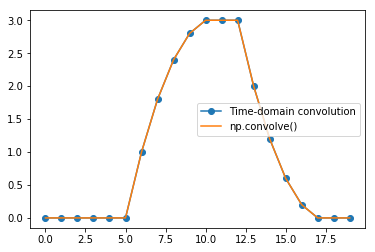

In [ ]:
# compare "manual" and Python convolution result


py_conv = np.convolve(signal1,kernel,'same')


plt.plot(conv_res,'o-',label='Time-domain convolution')
plt.plot(py_conv,'-',label='np.convolve()')
plt.legend()
plt.show()


---
# VIDEO: The convolution theorem
---


In [ ]:
## generate signal and kernel

# signal
signal1 = np.zeros(20)
signal1[8:15] = 1

# convolution kernel
kernel = [1, .8, .6, .4, .2]

# convolution sizes
nSign = len(signal1)
nKern = len(kernel)
nConv = nSign + nKern - 1


In [ ]:
## time-domain convolution

half_kern = int( np.floor(nKern/2) )

# flipped version of kernel
kflip = kernel[::-1]

# zero-padded data for convolution
dat4conv = np.concatenate( (np.zeros(half_kern),signal1,np.zeros(half_kern)) ,axis=0)

# initialize convolution output
conv_res = np.zeros(nConv)

# run convolution
for ti in range(half_kern,nConv-half_kern):

    # get a chunk of data
    tempdata = dat4conv[ti-half_kern:ti+half_kern+1]

    # compute dot product (don't forget to flip the kernel backwards!)
    conv_res[ti] = np.sum( tempdata*kflip )

# cut off edges
conv_res = conv_res[half_kern+1:-half_kern]


In [ ]:
## convolution implemented in the frequency domain

# spectra of signal and kernel
signalX = scipy.fftpack.fft(signal1,nConv)
kernelX = scipy.fftpack.fft(kernel,nConv)

# element-wise multiply
sigXkern = signalX * kernelX

# inverse FFT to get back to the time domain
conv_resFFT = np.real( scipy.fftpack.ifft( sigXkern ) )

# cut off edges
conv_resFFT = conv_resFFT[half_kern+1:-half_kern]


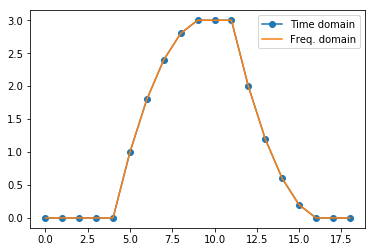

In [ ]:
## plot for comparison

plt.plot(conv_res,'o-',label='Time domain')
plt.plot(conv_resFFT,'-',label='Freq. domain')
plt.legend()
plt.show()


---
# VIDEO: Convolution with time-domain Gaussian (smoothing filter)
---


In [ ]:
# simulation parameters
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation


## create signal
# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl    = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise   = noiseamp * np.random.randn(n)
signal1 = ampl + noise

# subtract mean to eliminate DC
signal1 = signal1 - np.mean(signal1)


## create the Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms

# normalized time vector in ms
k = 100
gtime = 1000*np.arange(-k,k)/srate

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)


In [ ]:
### filter as time-domain convolution

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal1)

# implement the running mean filter
for i in range(k+1,n-k-1):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum( signal1[i-k:i+k]*gauswin )



## now repeat in the frequency domain

# compute N's
nConv = n + 2*k+1 - 1

# FFTs
dataX = scipy.fftpack.fft(signal1,nConv)
gausX = scipy.fftpack.fft(gauswin,nConv)

# IFFT
convres = np.real( scipy.fftpack.ifft( dataX*gausX ) )

# cut wings
convres = convres[k:-k]

# frequencies vector
hz = np.linspace(0,srate,nConv)


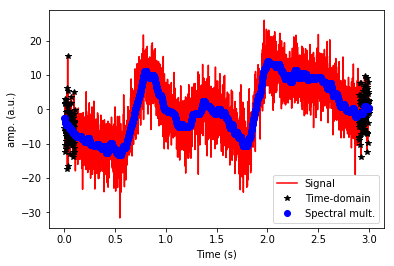

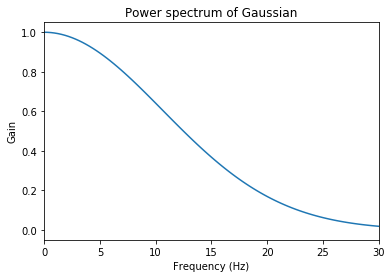

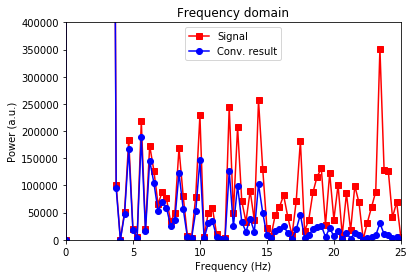

In [ ]:
### time-domain plot

# lines
plt.plot(time,signal1,'r',label='Signal')
plt.plot(time,filtsigG,'k*',label='Time-domain')
plt.plot(time,convres,'bo',label='Spectral mult.')
plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.show()




### frequency-domain plot

# plot Gaussian kernel
plt.plot(hz,np.abs(gausX)**2)
plt.xlim([0,30])
plt.ylabel('Gain'), plt.xlabel('Frequency (Hz)')
plt.title('Power spectrum of Gaussian')
plt.show()


# raw and filtered data spectra
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*gausX)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,25])
plt.ylim([0,400000])
plt.show()


---
# VIDEO: Convolution with frequency-domain Gaussian (narrowband filter)
---


In [ ]:
## create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal1= ampl + noise

# subtract mean to eliminate DC
signal1 = signal1 - np.mean(signal1)


## create Gaussian spectral shape
# Gaussian parameters (in Hz)
peakf = 11
fwhm  = 5.2

# vector of frequencies
hz = np.linspace(0,srate,n)

# frequency-domain Gaussian
s  = fwhm*(2*np.pi-1)/(4*np.pi)  # normalized width
x  = hz-peakf              # shifted frequencies
fx = np.exp(-.5*(x/s)**2)     # gaussian


In [ ]:
## now for convolution

# FFTs
dataX = scipy.fftpack.fft(signal1)

# IFFT
convres = 2*np.real( scipy.fftpack.ifft( dataX*fx ))

# frequencies vector
hz = np.linspace(0,srate,n)


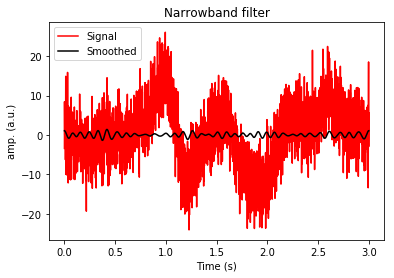

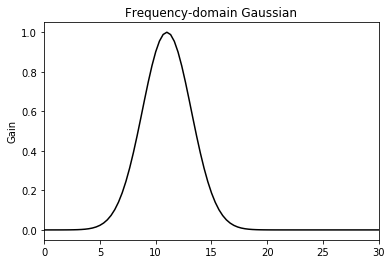

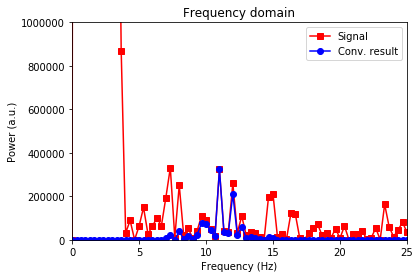

In [ ]:
### time-domain plot

# lines
plt.plot(time,signal1,'r',label='Signal')
plt.plot(time,convres,'k',label='Smoothed')
plt.xlabel('Time (s)'), plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Narrowband filter')
plt.show()



### frequency-domain plot

# plot Gaussian kernel
plt.plot(hz,fx,'k')
plt.xlim([0,30])
plt.ylabel('Gain')
plt.title('Frequency-domain Gaussian')
plt.show()

# raw and filtered data spectra
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*fx)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,25])
plt.ylim([0,1e6])
plt.show()


---
# VIDEO: Convolution with Planck taper (bandpass filter)
---


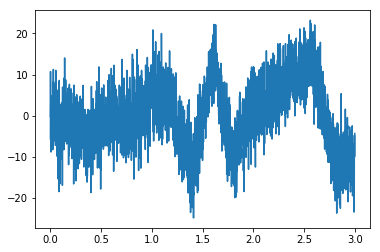

In [ ]:
## create the signal

srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal1= ampl + noise

# subtract mean to eliminate DC
signal1 = signal1 - np.mean(signal1)

plt.plot(time,signal1)
plt.show()

In [ ]:
## create Planck spectral shape

# frequencies
hz = np.linspace(0,srate,n)

# edge decay, must be between 0 and .5
eta = .15

# spectral parameters
fwhm  = 13
peakf = 20

# convert fwhm to indices
mp = np.round( 2*fwhm*n/srate ) # in MATLAB this is np, but np=numpy
pt = np.arange(1,mp+1)

# find center point index
fidx = np.argmin( (hz-peakf)**2 )


# define left and right exponentials
Zl = eta*(mp-1) * ( 1/pt + 1/(pt-eta*(mp-1)) )
Zr = eta*(mp-1) * ( 1/(mp-1-pt) + 1/( (1-eta)*(mp-1)-pt ) )

# create the taper
offset = mp%2
bounds = [ np.floor(eta*(mp-1))-offset , np.ceil((1-eta)*(mp-(1-offset))) ]
plancktaper = np.concatenate( (1/(np.exp(Zl[range(0,int(bounds[0]))])+1) ,np.ones(int(np.diff(bounds)+1)), 1/(np.exp(Zr[range(int(bounds[1]),len(Zr)-1)])+1)) ,axis=0)

# put the taper inside zeros
px = np.zeros( len(hz) )
pidx = range( int(np.max((0,fidx-np.floor(mp/2)+1))) , int(fidx+np.floor(mp/2)-mp%2+1) )
px[np.round(pidx)] = plancktaper


/home/mxc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
## now for convolution

# FFTs
dataX = scipy.fftpack.fft(signal1)

# IFFT
convres = 2*np.real( scipy.fftpack.ifft( dataX*px ))

# frequencies vector
hz = np.linspace(0,srate,n)


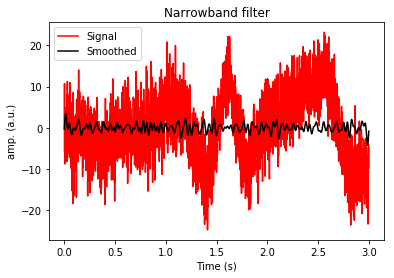

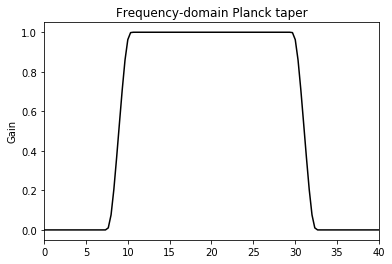

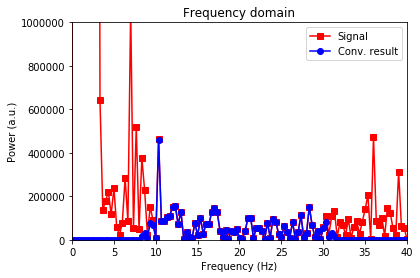

In [ ]:
### time-domain plots

# lines
plt.plot(time,signal1,'r',label='Signal')
plt.plot(time,convres,'k',label='Smoothed')
plt.xlabel('Time (s)'), plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Narrowband filter')
plt.show()


### frequency-domain plot

# plot Gaussian kernel
plt.plot(hz,px,'k')
plt.xlim([0,peakf*2])
plt.ylabel('Gain')
plt.title('Frequency-domain Planck taper')
plt.show()

# raw and filtered data spectra
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*px)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,peakf*2])
plt.ylim([0,1e6])
plt.show()